In [136]:
import numpy as np
import matplotlib.pyplot as plt

import autograd.numpy as npa

import legume
legume.set_backend('autograd')
import legume_backend

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 16

hole_radius, slab_thickness, refractive_index, x_shift = legume_backend.L3_params_520()

x_pos, y_pos = legume_backend.phc_cavity_holes_array('L3', Nx, Ny)
x_pos[0] = x_pos[0] + x_shift

weights_name = 'L3_520nm_weights_step_size_500_gmax_2_kpoints_3_loss_V4_Q_target_10e5_phc_size_16_ffgauss_0.3'
file_name = rf'./weights_520_14.10.2024/param_history/{weights_name}_param_history.npy'
param_history = np.load(file_name, allow_pickle=True)
param_history = param_history.reshape(param_history.shape[0]//(2*len(y_pos)), 2*len(y_pos))
parameters = param_history[-1]

dx = parameters[0: len(x_pos)]
dy = parameters[len(x_pos):]
    
# Initialize shift parameters to zeros
# dx, dy = np.zeros((len(x_pos),)), np.zeros((len(y_pos),))

In [ ]:
L3_phc = legume_backend.design_phc(Nx, Ny, x_pos, y_pos, hole_radius, slab_thickness, refractive_index, dx, dy)

# Set some GME options
num_modes = 30
options = {'gmode_inds': [0], 'verbose': True, 'eig_sigma': 0.4, 
           'numeig': num_modes, 'gradients': 'approx', 'compute_im': False,
           'eig_solver': 'eigsh'}

kpoints = 2
gmax = 2
gaussian_width = 1.65

kpoints_array = legume_backend.get_kpoints(Nx, Ny, nkx = kpoints, nky = kpoints)

eigvec = np.load(f'./Legume_eigenvectors/L3_520nm_eigvecs_gmax={gmax}.npy', allow_pickle=True)
(gme, quality_factor, overlap, indmode) = legume_backend.gme_cavity_dot(L3_phc, gmax = gmax, 
                                                gaussian_width = gaussian_width, kpoints = kpoints_array, 
                                                gme_options = options, eigvec = eigvec)

# (gme, f_imag_array, direction_ratio, indmode) = legume_backend.gme_cavity(L3_phc, Nx, Ny, gaussian_width, gmax, kpoints_array, options)

print("Quality Factor = ", quality_factor, "overlap = ", quality_factor)
    

# ax = legume.viz.field(gme, 'e', 0, indmode, z=slab_thickness/2, component='y', val='abs', N1=300, N2=200)

KeyboardInterrupt: 

0.10661093815488225


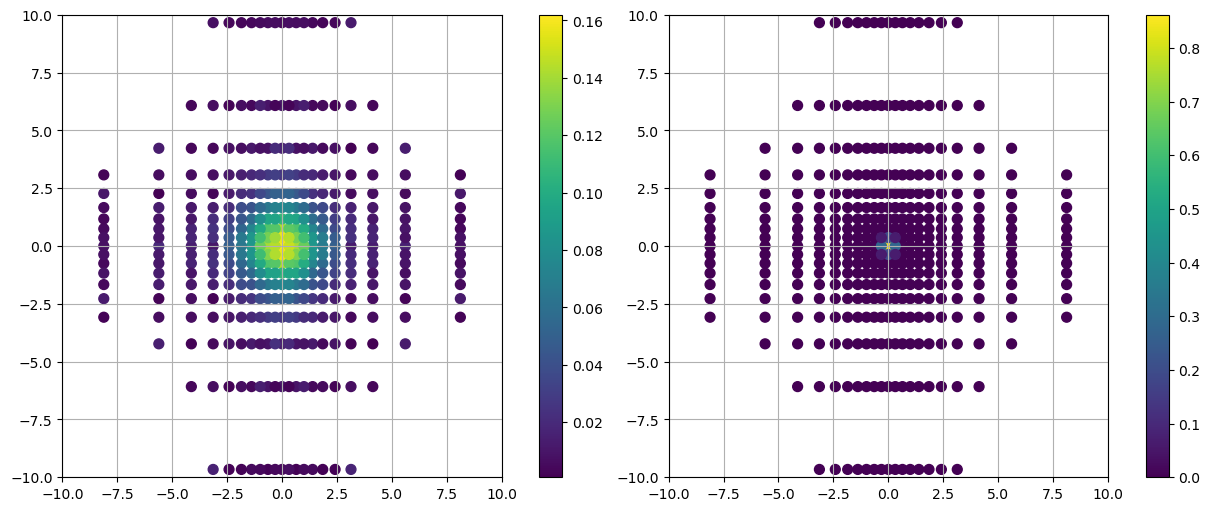

In [ ]:
gaussian_width = 0.3

rad_array = []
rad_array_te = []
rad_array_tm = []
x_array = []
y_array = []

for i in range(kpoints**2):

    (freq_im, rad_coup, rad_gvec) = gme.compute_rad(i, [indmode])

    x = npa.asarray(rad_gvec['u'][0][0]) + kpoints_array[0, i]
    x_array.extend(x)
    y = npa.asarray(rad_gvec['u'][0][1]) + kpoints_array[1, i]
    y_array.extend(y)

    # rad_tot = 1/(npa.pi*0.5**2)*npa.exp(-(x**2 + y**2)/(2*0.5**2))
    # rad = rad_tot/np.sqrt(npa.sum(rad_tot**2))
    rad_tot = npa.sum(npa.abs(rad_coup['l_te'][0])**2) + npa.sum(npa.abs(rad_coup['l_tm'][0])**2)
    rad_arg = np.angle(rad_coup['l_te'][0] - 1j*rad_coup['l_tm'][0])
    rad = npa.abs(rad_coup['l_te'][0])**2 + npa.abs(rad_coup['l_tm'][0])**2
    rad_array.extend(rad)
    
    rad_array_te.extend(rad_coup['l_te'][0])
    rad_array_tm.extend(rad_coup['l_tm'][0])
k_norm = 2*np.pi*gme.freqs[0, indmode] + 0.01
x_array = np.asarray(x_array)/k_norm
y_array = np.asarray(y_array)/k_norm
x_array = 4*x_array/(1 - x_array**2)
y_array = 4*y_array/(1 - y_array**2)

rad_array = np.asarray(rad_array)
rad_array_te = np.asarray(rad_array_te)
rad_array_tm = np.asarray(rad_array_tm)

sine = np.sqrt(x_array**2 + y_array**2)

rad_array_tot = np.sum(rad_array)
rad_array_norm = np.sqrt(rad_array)/np.sqrt(rad_array_tot)
rad_array_te_norm = np.sqrt(rad_array_te)/np.sqrt(npa.sum(rad_array_te**2))
rad_array_tm_norm = np.sqrt(rad_array_tm)/np.sqrt(npa.sum(rad_array_tm**2))

target_gaussian = 1/(npa.pi*gaussian_width**2)*npa.exp(-(x_array**2 + y_array**2)/(gaussian_width**2))
target_gaussian_norm = target_gaussian/npa.sqrt(npa.sum(target_gaussian**2))

overlap = npa.dot(rad_array_norm,target_gaussian_norm)**2

angle = np.arctan(np.abs(rad_array_te)/np.abs(rad_array_tm))

test = np.sqrt(rad_array + 2*np.abs(rad_array_te)*np.abs(rad_array_tm)*np.cos(np.angle(rad_array_te) - np.angle(rad_array_tm)))

print(overlap)

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize = (12, 5))
p = ax1.scatter(x_array, y_array, c=rad_array_norm, cmap = 'viridis', s = 50)
q = ax2.scatter(x_array, y_array, c=target_gaussian_norm, cmap = 'viridis', s = 50)
cbar = plt.colorbar(p, ax=ax1)
cbar = plt.colorbar(q, ax=ax2)
ax1.set_xlim((-10, 10))
ax2.set_xlim((-10, 10))
ax1.set_ylim((-10, 10))
ax2.set_ylim((-10, 10))
ax1.grid()
ax2.grid()

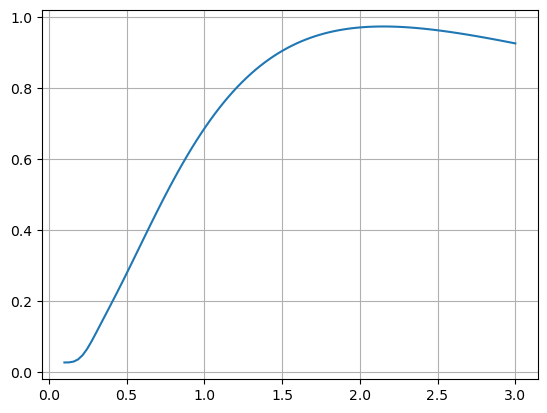

In [ ]:
gaussian_width_array = np.linspace(0.1, 3, 100)
overlap_array = np.zeros(len(gaussian_width_array))

for idx, gaussian_width in enumerate(gaussian_width_array):
    
    target_gaussian = 1/(npa.pi*gaussian_width**2)*npa.exp(-(x_array**2 + y_array**2)/(gaussian_width**2))
    target_gaussian_norm = target_gaussian/npa.sqrt(npa.sum(target_gaussian**2))
    
    overlap_array[idx] = npa.dot(rad_array_norm,target_gaussian_norm)**2
    
plt.plot(gaussian_width_array, overlap_array)   
plt.grid()

### Sweep parameters to check the variation of gaussian overlap

In [ ]:
# Sweep kpoints

# Set some GME options
num_modes = 30
options = {'gmode_inds': [0], 'verbose': False, 'eig_sigma': 0.4, 
           'numeig': num_modes, 'gradients': 'approx', 'compute_im': False,
           'eig_solver': 'eigsh'}

kpoints_range = np.arange(4)+1
quality_factor_array = np.zeros(len(kpoints_range))
gaussian_overlap_array = np.zeros(len(kpoints_range))

gmax = 2
gaussian_width = 1.65

for idx, kpoints in enumerate(kpoints_range):
    kpoints_array = legume_backend.get_kpoints(Nx, Ny, nkx = kpoints, nky = kpoints)

    (gme, quality_factor, directionality, indmode) = legume_backend.gme_cavity_dot(L3_phc, gmax = gmax, 
                                                    gaussian_width = gaussian_width, kpoints = kpoints_array, 
                                                    gme_options = options, eigvec = eigvec)

    quality_factor_array[idx] = quality_factor
    gaussian_overlap_array[idx] = directionality
    
    print(f"kpoints = {kpoints}: Q = {np.round(quality_factor)}, overlap = {np.round(directionality, 3)}")

kpoints = 1: Q = 97582.0, overlap = 0.962
kpoints = 2: Q = 100150.0, overlap = 0.966
kpoints = 3: Q = 98732.0, overlap = 0.953
